# Inside Airbnb Madrid: Calendar Price Data Investigation

Objective: Diagnose price data availability in `calendar.csv` and create a clean dataset for analysis.

Key Questions:
1. Are price columns genuinely empty (100% NaN)?
2. If not, can we extract prices from `listings.csv` and merge them?
3. What parsing strategy is needed for price conversion?

Output: Clean parquet file with validated data.

---

## Environment Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration - Updated paths
# If we're in notebooks/ or scripts/, go up to project root
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name in ['notebooks', 'scripts'] else Path.cwd()
DATASET_DIR = PROJECT_ROOT / "data"  # CSV files are here
OUTPUT_DIR = DATASET_DIR / "processed"  # Processed output
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
sns.set_style("whitegrid")

print("✓ Environment initialized")
print(f"Dataset directory: {DATASET_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

✓ Environment initialized
Dataset directory: /Users/virginiadimauro/Desktop/UNITN/Secondo Anno/Geospatial Analysis/geospatial-project/data
Output directory: /Users/virginiadimauro/Desktop/UNITN/Secondo Anno/Geospatial Analysis/geospatial-project/data/processed


## 1. Initial Price Diagnosis

Load `calendar.csv` with price columns forced as strings to preserve original formatting, then analyze null/empty patterns.

In [2]:
# Load calendar with price columns as strings to preserve original format
# MODIFICATION 1: Use int64 for listing_id to avoid overflow (int32 max ~2B)
calendar_file = DATASET_DIR / "calendar.csv"

# First, check file size and basic info
file_size_mb = calendar_file.stat().st_size / (1024**2)
print(f"File: {calendar_file.name}")
print(f"Size: {file_size_mb:.2f} MB\n")

# Read entire dataset with int64 for listing_id (prevent overflow)
dtypes_spec = {
    'listing_id': 'int64',  # CHANGED: int32 -> int64 to prevent overflow
    'date': 'object',
    'available': 'object',
    'price': 'string',  # Force string to preserve formatting
    'adjusted_price': 'string',  # Force string to preserve formatting
    'minimum_nights': 'int32',
    'maximum_nights': 'int32'
}

print("Loading calendar.csv with int64 for listing_id...")
df_cal = pd.read_csv(calendar_file, dtype=dtypes_spec)
print(f"✓ Loaded: {len(df_cal):,} rows × {len(df_cal.columns)} columns")
print(f"Memory usage: {df_cal.memory_usage(deep=True).sum() / (1024**2):.2f} MB\n")

# INTEGRITY CHECK: Ensure no negative listing_ids (overflow detection)
assert df_cal['listing_id'].min() >= 0, f"ERROR: Negative listing_id detected! Min={df_cal['listing_id'].min()}"
print(f"✓ listing_id integrity check passed: min={df_cal['listing_id'].min()}, max={df_cal['listing_id'].max()}")
print(f"✓ Unique listing_ids: {df_cal['listing_id'].nunique():,}\n")

# Display basic info
print(df_cal.info())

File: calendar.csv
Size: 324.18 MB

Loading calendar.csv with int64 for listing_id...
✓ Loaded: 9,125,007 rows × 7 columns
Memory usage: 1229.20 MB

✓ listing_id integrity check passed: min=21853, max=1508659056613604207
✓ Unique listing_ids: 25,000

<class 'pandas.DataFrame'>
RangeIndex: 9125007 entries, 0 to 9125006
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   listing_id      int64 
 1   date            object
 2   available       object
 3   price           string
 4   adjusted_price  string
 5   minimum_nights  int32 
 6   maximum_nights  int32 
dtypes: int32(2), int64(1), object(2), string(2)
memory usage: 419.9+ MB
None


In [3]:
# Detailed analysis of price columns
print("\n" + "="*80)
print("PRICE COLUMN DIAGNOSIS")
print("="*80)

for col in ['price', 'adjusted_price']:
    print(f"\n--- {col.upper()} ---")
    
    non_null_count = df_cal[col].notna().sum()
    null_count = df_cal[col].isna().sum()
    empty_str_count = (df_cal[col] == '').sum()
    
    print(f"Non-null values: {non_null_count:,} ({100*non_null_count/len(df_cal):.2f}%)")
    print(f"Null (NaN): {null_count:,} ({100*null_count/len(df_cal):.2f}%)")
    print(f"Empty strings: {empty_str_count:,} ({100*empty_str_count/len(df_cal):.2f}%)")
    
    # Show value distribution
    print(f"\nValue distribution (top 20, including NaN):")
    vc = df_cal[col].value_counts(dropna=False).head(20)
    for val, count in vc.items():
        if pd.isna(val):
            print(f"  [NaN]: {count:,}")
        elif val == '':
            print(f"  [empty string]: {count:,}")
        else:
            print(f"  '{val}': {count:,}")

# Check for unique non-null values
print("\n" + "="*80)
print("SAMPLE OF NON-NULL PRICE VALUES")
print("="*80)

for col in ['price', 'adjusted_price']:
    non_null_samples = df_cal[df_cal[col].notna()][col].unique()[:10]
    if len(non_null_samples) > 0:
        print(f"\n{col} samples: {non_null_samples}")
    else:
        print(f"\n{col}: NO NON-NULL VALUES FOUND")


PRICE COLUMN DIAGNOSIS

--- PRICE ---
Non-null values: 0 (0.00%)
Null (NaN): 9,125,007 (100.00%)
Empty strings: 0 (0.00%)

Value distribution (top 20, including NaN):
  [NaN]: 9,125,007

--- ADJUSTED_PRICE ---
Non-null values: 0 (0.00%)
Null (NaN): 9,125,007 (100.00%)
Empty strings: 0 (0.00%)

Value distribution (top 20, including NaN):
  [NaN]: 9,125,007

SAMPLE OF NON-NULL PRICE VALUES

price: NO NON-NULL VALUES FOUND

adjusted_price: NO NON-NULL VALUES FOUND


In [4]:

# MODIFICATION 2: FORENSIC DIAGNOSIS - Prove that calendar.csv prices are 100% empty
print("\n" + "="*80)
print("FORENSIC DIAGNOSIS: CALENDAR PRICE COLUMNS (100% EMPTY CONFIRMATION)")
print("="*80)

# Re-read calendar with string dtype to catch any edge cases (usecols to avoid rereading 9M rows)
cal_forensic = pd.read_csv(
    calendar_file, 
    usecols=['listing_id', 'price', 'adjusted_price'],  # Only read necessary columns
    dtype={"price": "string", "adjusted_price": "string", "listing_id": "int64"}
)

for col in ['price', 'adjusted_price']:
    nan_pct = cal_forensic[col].isna().mean() * 100
    empty_pct = cal_forensic[col].fillna("").eq("").mean() * 100
    total_empty = 100 - (cal_forensic[col].notna() & (cal_forensic[col] != "")).mean() * 100
    
    print(f"\n{col}:")
    print(f"  NaN percentage: {nan_pct:.2f}%")
    print(f"  Empty string percentage: {empty_pct:.2f}%")
    print(f"  Total empty (NaN + empty strings): {total_empty:.2f}%")
    print(f"  Non-empty values: {(cal_forensic[col].notna() & (cal_forensic[col] != '')).sum():,}")
    
    print(f"\n  Top 5 values (with NaN):")
    vc = cal_forensic[col].value_counts(dropna=False).head(5)
    for val, cnt in vc.items():
        if pd.isna(val):
            print(f"    [NaN]: {cnt:,}")
        elif val == "":
            print(f"    [empty string]: {cnt:,}")
        else:
            print(f"    '{val}': {cnt:,}")

print("\n" + "-"*80)
print("CONCLUSION:")
print("✓ calendar.csv does NOT provide daily prices in this snapshot")

print("✓ Only AVAILABILITY is usable from calendar.csv")

print("✓ Prices will be extracted from listings.csv (static per listing)")
print("-"*80)


FORENSIC DIAGNOSIS: CALENDAR PRICE COLUMNS (100% EMPTY CONFIRMATION)

price:
  NaN percentage: 100.00%
  Empty string percentage: 100.00%
  Total empty (NaN + empty strings): 100.00%
  Non-empty values: 0

  Top 5 values (with NaN):
    [NaN]: 9,125,007

adjusted_price:
  NaN percentage: 100.00%
  Empty string percentage: 100.00%
  Total empty (NaN + empty strings): 100.00%
  Non-empty values: 0

  Top 5 values (with NaN):
    [NaN]: 9,125,007

--------------------------------------------------------------------------------
CONCLUSION:
✓ calendar.csv does NOT provide daily prices in this snapshot
✓ Only AVAILABILITY is usable from calendar.csv
✓ Prices will be extracted from listings.csv (static per listing)
--------------------------------------------------------------------------------


## 2. Checking for Currency Symbols and Formatting

Analyze raw data for presence of €, $, commas, and other formatting characters.

In [5]:
# Check for special characters in non-null values
import re

def check_special_chars(series, col_name):
    """Check for currency symbols and formatting chars"""
    non_null = series[series.notna()]
    
    if len(non_null) == 0:
        print(f"\n{col_name}: NO DATA TO ANALYZE")
        return
    
    print(f"\n{col_name}: Analyzing {len(non_null):,} non-null values...")
    
    has_dollar = non_null.str.contains('\$', regex=False).any()
    has_euro = non_null.str.contains('€', regex=False).any()
    has_comma = non_null.str.contains(',', regex=False).any()
    has_dot = non_null.str.contains('\.', regex=True).any()
    has_space = non_null.str.contains(' ', regex=False).any()
    
    print(f"  Contains $: {has_dollar}")
    print(f"  Contains €: {has_euro}")
    print(f"  Contains comma (,): {has_comma}")
    print(f"  Contains dot (.): {has_dot}")
    print(f"  Contains space: {has_space}")
    
    # Show sample raw values
    print(f"\n  Sample raw values (first 10):")
    for val in non_null.head(10):
        print(f"    '{val}'")

print("="*80)
print("SPECIAL CHARACTER DETECTION")
print("="*80)

check_special_chars(df_cal['price'], 'PRICE')
check_special_chars(df_cal['adjusted_price'], 'ADJUSTED_PRICE')

SPECIAL CHARACTER DETECTION

PRICE: NO DATA TO ANALYZE

ADJUSTED_PRICE: NO DATA TO ANALYZE


## 3. Strategy: Loading Prices from listings.csv

Since `calendar.csv` has no price data, we'll extract prices from `listings.csv` and merge them by `listing_id`.

In [6]:
# Load listings data
# MODIFICATION 1b: Use int64 for id to match calendar listing_id (prevent merge issues)
listings_file = DATASET_DIR / "listings.csv"

print(f"Loading {listings_file.name}...")
df_listings = pd.read_csv(listings_file, dtype={'id': 'int64', 'price': 'string'},  # CHANGED: int32 -> int64
                          usecols=['id', 'price'])

print(f"✓ Loaded: {len(df_listings):,} listings\n")

# INTEGRITY CHECK: Ensure no negative ids (overflow detection)
assert df_listings['id'].min() >= 0, f"ERROR: Negative id detected! Min={df_listings['id'].min()}"
print(f"✓ id integrity check passed: min={df_listings['id'].min()}, max={df_listings['id'].max()}")
print(f"✓ Unique ids: {df_listings['id'].nunique():,}\n")

# Analyze price formatting in listings
print("="*80)
print("PRICE COLUMN IN LISTINGS.CSV")
print("="*80)

print(f"\nNon-null prices: {df_listings['price'].notna().sum():,}")
print(f"Null prices: {df_listings['price'].isna().sum():,}")

print("\nSample raw price values from listings:")
print(df_listings['price'].dropna().head(20).values)

print("\nValue distribution (top 10):")
print(df_listings['price'].value_counts(dropna=False).head(10))

Loading listings.csv...
✓ Loaded: 25,000 listings

✓ id integrity check passed: min=21853, max=1508659056613604207
✓ Unique ids: 25,000

PRICE COLUMN IN LISTINGS.CSV

Non-null prices: 18,953
Null prices: 6,047

Sample raw price values from listings:
<ArrowStringArray>
['$157.00', '$143.00',  '$65.00', '$116.00',  '$79.00', '$300.00', '$166.00',
  '$45.00',  '$24.00',  '$90.00',  '$60.00', '$120.00', '$160.00',  '$98.00',
  '$68.00', '$117.00',  '$58.00',  '$70.00', '$138.00', '$100.00']
Length: 20, dtype: string

Value distribution (top 10):
price
<NA>       6047
$90.00      216
$80.00      174
$100.00     164
$85.00      164
$60.00      161
$110.00     158
$105.00     157
$40.00      154
$65.00      150
Name: count, dtype: int64[pyarrow]


## 4. Robust Price Parsing

Implement a parsing function to extract numeric prices, handling currency symbols and thousand separators.

In [7]:
# MODIFICATION 3: Robust price parsing with regex
print("="*80)
print("ROBUST PRICE PARSING (MODIFICATION 3)")
print("="*80)

# Method: Use regex to remove currency symbols and separators
df_listings['price_num'] = (df_listings['price']
    .astype('string')
    .str.replace(r'[^\d,.\-]', '', regex=True)  # Remove all non-numeric chars except comma, dot, minus
    .str.replace(',', '', regex=False)            # Remove commas (thousand separators)
    .replace('', pd.NA)                           # Convert empty strings to NA
    .astype('Float64'))                           # Convert to nullable Float64

# Verification
valid_count = df_listings['price_num'].notna().sum()
valid_pct = 100 * valid_count / len(df_listings)
print(f"\n✓ Price parsing complete:")
print(f"  Valid prices (non-null): {valid_count:,} ({valid_pct:.2f}%)")
print(f"  Null prices: {df_listings['price_num'].isna().sum():,}")

if valid_count > 0:
    print(f"\nPrice statistics (non-null only):")
    print(f"  Min: €{df_listings['price_num'].min():.2f}")
    print(f"  Max: €{df_listings['price_num'].max():.2f}")
    print(f"  Mean: €{df_listings['price_num'].mean():.2f}")
    print(f"  Median: €{df_listings['price_num'].median():.2f}")
    print(f"  Std Dev: €{df_listings['price_num'].std():.2f}")

# Show before/after examples
print("\n" + "-"*80)
print("Before/After Examples (first 10 non-null):")
before_after = df_listings[df_listings['price'].notna()][['price', 'price_num']].head(10)
for idx, row in before_after.iterrows():
    formatted = f"{row['price_num']:>10.2f}" if pd.notna(row['price_num']) else "        None"
    print(f"  '{row['price']:>15}' → €{formatted}")

ROBUST PRICE PARSING (MODIFICATION 3)

✓ Price parsing complete:
  Valid prices (non-null): 18,953 (75.81%)
  Null prices: 6,047

Price statistics (non-null only):
  Min: €8.00
  Max: €25654.00
  Mean: €156.69
  Median: €110.00
  Std Dev: €492.26

--------------------------------------------------------------------------------
Before/After Examples (first 10 non-null):
  '        $157.00' → €    157.00
  '        $143.00' → €    143.00
  '         $65.00' → €     65.00
  '        $116.00' → €    116.00
  '         $79.00' → €     79.00
  '        $300.00' → €    300.00
  '        $166.00' → €    166.00
  '         $45.00' → €     45.00
  '         $24.00' → €     24.00
  '         $90.00' → €     90.00


## 5. Merging Calendar with Prices

Merge calendar data with parsed prices from listings using `listing_id`.

In [8]:
# MODIFICATION 4: Merge with comprehensive integrity checks
print("="*80)
print("MERGE + INTEGRITY CHECKS (MODIFICATION 4)")
print("="*80)

# Prepare calendar data for merging
df_clean = df_cal.copy()

# Convert date to datetime
df_clean['date'] = pd.to_datetime(df_clean['date'], format='%Y-%m-%d')

# Convert available to boolean
df_clean['available'] = df_clean['available'].map({'t': True, 'f': False})

print(f"\nCalendar shape before merge: {df_clean.shape}")
print(f"Date range: {df_clean['date'].min().date()} to {df_clean['date'].max().date()}")
print(f"Unique listings: {df_clean['listing_id'].nunique():,}")

# Merge with listings price
print("\nMerging with listings prices...")
df_listings_for_merge = df_listings[['id', 'price_num']].copy()
df_listings_for_merge.rename(columns={'id': 'listing_id', 'price_num': 'price_num'}, inplace=True)

df_clean = df_clean.merge(df_listings_for_merge, on='listing_id', how='left')

print(f"✓ Merged successfully")

# INTEGRITY CHECKS
print("\n" + "-"*80)
print("INTEGRITY CHECKS:")

# Check 1: No negative listing_ids after merge
assert df_clean['listing_id'].min() >= 0, f"ERROR: Negative listing_id after merge! Min={df_clean['listing_id'].min()}"
print("✓ Check 1: No negative listing_ids")

# Check 2: No duplicates on (listing_id, date)
duplicates_merged = df_clean.duplicated(subset=['listing_id', 'date']).sum()
assert duplicates_merged == 0, f"ERROR: Found {duplicates_merged} duplicates on (listing_id, date)!"
print(f"✓ Check 2: Zero duplicates on (listing_id, date): {duplicates_merged}")

# Check 3: Price coverage metrics
price_valid = df_clean['price_num'].notna().sum()
price_null = df_clean['price_num'].isna().sum()
price_coverage_rows = 100 * price_valid / len(df_clean)

unique_listings = df_clean['listing_id'].nunique()
listings_with_price = df_clean[df_clean['price_num'].notna()]['listing_id'].nunique()
price_coverage_listings = 100 * listings_with_price / unique_listings

print(f"✓ Check 3: Price coverage")
print(f"    - Rows with price_num: {price_valid:,} / {len(df_clean):,} ({price_coverage_rows:.1f}%)")
print(f"    - Listings with price: {listings_with_price:,} / {unique_listings:,} ({price_coverage_listings:.1f}%)")
print(f"    - Rows without price: {price_null:,}")

print("\n✓ All integrity checks passed!")

MERGE + INTEGRITY CHECKS (MODIFICATION 4)

Calendar shape before merge: (9125007, 7)
Date range: 2025-09-14 to 2026-09-14
Unique listings: 25,000

Merging with listings prices...
✓ Merged successfully

--------------------------------------------------------------------------------
INTEGRITY CHECKS:
✓ Check 1: No negative listing_ids
✓ Check 2: Zero duplicates on (listing_id, date): 0
✓ Check 3: Price coverage
    - Rows with price_num: 6,917,852 / 9,125,007 (75.8%)
    - Listings with price: 18,953 / 25,000 (75.8%)
    - Rows without price: 2,207,155

✓ All integrity checks passed!


## 6. Creating Final Clean Dataset

Build the final clean dataset with proper data types and validate data quality.

In [9]:
# Select final columns and optimize dtypes
print("="*80)
print("BUILDING FINAL DATASET")
print("="*80)

df_final = df_clean[[
    'listing_id', 
    'date', 
    'available', 
    'minimum_nights',
    'maximum_nights',
    'price_num'
]].copy()

# Rename columns for clarity
df_final.columns = [
    'listing_id',
    'date',
    'available',
    'min_nights',
    'max_nights',
    'price'
]

# Optimize dtypes for storage
df_final = df_final.astype({
    'listing_id': 'int64',  # CHANGED: int32 -> int64 to match source
    'date': 'datetime64[ns]',
    'available': 'bool',
    'min_nights': 'int32',
    'max_nights': 'int32',
    'price': 'Float64'  # Float64 allows NaN in numeric column
})

# Sort for better query performance
df_final = df_final.sort_values(['listing_id', 'date']).reset_index(drop=True)

print(f"\nFinal dataset shape: {df_final.shape}")
print(f"\nData types:")
print(df_final.dtypes)
print(f"\nMemory usage: {df_final.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
print(f"\nFirst 10 rows:")
print(df_final.head(10))

BUILDING FINAL DATASET

Final dataset shape: (9125007, 6)

Data types:
listing_id             int64
date          datetime64[ns]
available               bool
min_nights             int32
max_nights             int32
price                Float64
dtype: object

Memory usage: 295.88 MB

First 10 rows:
   listing_id       date  available  min_nights  max_nights  price
0       21853 2025-09-15      False           4          40   <NA>
1       21853 2025-09-16      False           4          40   <NA>
2       21853 2025-09-17      False           4          40   <NA>
3       21853 2025-09-18      False           4          40   <NA>
4       21853 2025-09-19      False           4          40   <NA>
5       21853 2025-09-20      False           4          40   <NA>
6       21853 2025-09-21      False           4          40   <NA>
7       21853 2025-09-22      False           4          40   <NA>
8       21853 2025-09-23      False           4          40   <NA>
9       21853 2025-09-24      

## 7. Data Quality Checks and Validation

Perform comprehensive data quality checks including duplicates, outliers, and data distribution.

In [10]:
print("="*80)
print("DATA QUALITY CHECKS")
print("="*80)

# 1. Duplicates
duplicates = df_final.duplicated(subset=['listing_id', 'date']).sum()
print(f"\n1. DUPLICATES")
print(f"   Duplicate rows (listing_id, date): {duplicates}")
if duplicates > 0:
    print("   ⚠️  WARNING: Duplicates detected!")
else:
    print("   ✓ No duplicates found")

# 2. Date range
print(f"\n2. DATE RANGE")
print(f"   Min: {df_final['date'].min().date()}")
print(f"   Max: {df_final['date'].max().date()}")
print(f"   Days covered: {(df_final['date'].max() - df_final['date'].min()).days}")

# 3. Availability distribution
print(f"\n3. AVAILABILITY DISTRIBUTION")
avail_counts = df_final['available'].value_counts()
for val, count in avail_counts.items():
    pct = 100 * count / len(df_final)
    print(f"   {val}: {count:,} ({pct:.1f}%)")

# 4. Minimum nights analysis
print(f"\n4. MINIMUM NIGHTS ANALYSIS")
print(f"   Min: {df_final['min_nights'].min()}")
print(f"   Max: {df_final['min_nights'].max()}")
print(f"   Mean: {df_final['min_nights'].mean():.1f}")
print(f"   Median: {df_final['min_nights'].median():.1f}")

# 5. Maximum nights analysis and outlier detection
print(f"\n5. MAXIMUM NIGHTS ANALYSIS")
print(f"   Min: {df_final['max_nights'].min()}")
print(f"   Max: {df_final['max_nights'].max():,}")
print(f"   Mean: {df_final['max_nights'].mean():.1f}")
print(f"   Median: {df_final['max_nights'].median():.1f}")

outlier_threshold = 365 * 5  # 5 years
outliers = (df_final['max_nights'] > outlier_threshold).sum()
print(f"   Extreme values (>5 years): {outliers:,} ({100*outliers/len(df_final):.2f}%)")

# 6. Price analysis
print(f"\n6. PRICE ANALYSIS")
price_valid = df_final['price'].notna().sum()
price_null = df_final['price'].isna().sum()
print(f"   Valid prices: {price_valid:,} ({100*price_valid/len(df_final):.1f}%)")
print(f"   Missing prices: {price_null:,} ({100*price_null/len(df_final):.1f}%)")

if price_valid > 0:
    print(f"\n   Price statistics (non-null only):")
    print(f"   Min: ${df_final['price'].min():.2f}")
    print(f"   Max: ${df_final['price'].max():.2f}")
    print(f"   Mean: ${df_final['price'].mean():.2f}")
    print(f"   Median: ${df_final['price'].median():.2f}")
    print(f"   Std Dev: ${df_final['price'].std():.2f}")
    
    # Check for outliers (e.g., prices > 1000)
    expensive = (df_final['price'] > 1000).sum()
    print(f"   Listings >$1000/night: {expensive:,} ({100*expensive/price_valid:.2f}%)")

# 7. Listing coverage
print(f"\n7. LISTING COVERAGE")
unique_listings_in_calendar = df_final['listing_id'].nunique()
print(f"   Unique listings: {unique_listings_in_calendar:,}")

listings_with_price = df_final[df_final['price'].notna()]['listing_id'].nunique()
print(f"   Listings with price: {listings_with_price:,} ({100*listings_with_price/unique_listings_in_calendar:.1f}%)")

DATA QUALITY CHECKS

1. DUPLICATES
   Duplicate rows (listing_id, date): 0
   ✓ No duplicates found

2. DATE RANGE
   Min: 2025-09-14
   Max: 2026-09-14
   Days covered: 365

3. AVAILABILITY DISTRIBUTION
   False: 4,882,360 (53.5%)
   True: 4,242,647 (46.5%)

4. MINIMUM NIGHTS ANALYSIS
   Min: 1
   Max: 1125
   Mean: 11.1
   Median: 3.0

5. MAXIMUM NIGHTS ANALYSIS
   Min: 1
   Max: 11,111
   Mean: 609.3
   Median: 365.0
   Extreme values (>5 years): 365 (0.00%)

6. PRICE ANALYSIS
   Valid prices: 6,917,852 (75.8%)
   Missing prices: 2,207,155 (24.2%)

   Price statistics (non-null only):
   Min: $8.00
   Max: $25654.00
   Mean: $156.69
   Median: $110.00
   Std Dev: $492.24
   Listings >$1000/night: 32,120 (0.46%)

7. LISTING COVERAGE
   Unique listings: 25,000
   Listings with price: 18,953 (75.8%)


## 8. Visualization of Key Distributions

✓ Visualization saved to: 01_data_quality_distributions.png


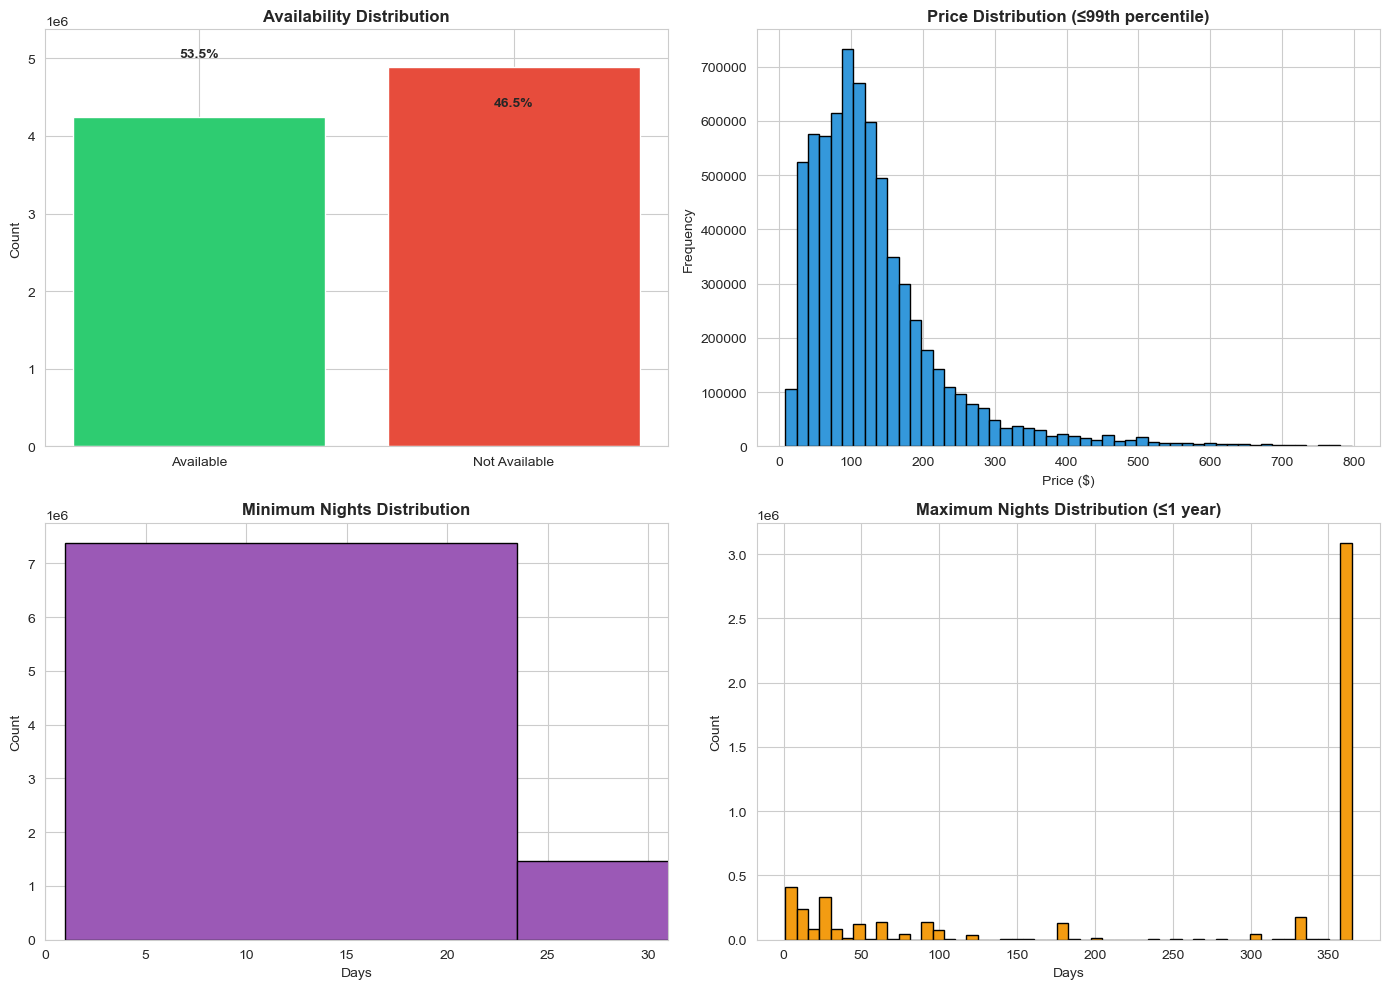

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Availability distribution
avail_counts = df_final['available'].value_counts()
axes[0, 0].bar(['Available', 'Not Available'], 
              [avail_counts[True], avail_counts[False]], 
              color=['#2ecc71', '#e74c3c'])
axes[0, 0].set_title('Availability Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_ylim(0, avail_counts.max() * 1.1)

# Add percentage labels
for i, (val, count) in enumerate(avail_counts.items()):
    pct = 100 * count / len(df_final)
    axes[0, 0].text(i, count + avail_counts.max()*0.02, f'{pct:.1f}%', 
                   ha='center', va='bottom', fontweight='bold')

# Plot 2: Price distribution (log scale if large range)
price_data = df_final['price'].dropna()
if len(price_data) > 0:
    axes[0, 1].hist(price_data[price_data <= price_data.quantile(0.99)], bins=50, edgecolor='black', color='#3498db')
    axes[0, 1].set_title('Price Distribution (≤99th percentile)', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Price ($)')
    axes[0, 1].set_ylabel('Frequency')

# Plot 3: Min nights distribution
axes[1, 0].hist(df_final['min_nights'], bins=50, edgecolor='black', color='#9b59b6')
axes[1, 0].set_title('Minimum Nights Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Days')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xlim(0, df_final['min_nights'].quantile(0.95))

# Plot 4: Max nights distribution (log scale)
max_nights_capped = df_final['max_nights'][df_final['max_nights'] <= 365]
axes[1, 1].hist(max_nights_capped, bins=50, edgecolor='black', color='#f39c12')
axes[1, 1].set_title('Maximum Nights Distribution (≤1 year)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Days')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.savefig(str(OUTPUT_DIR / "01_data_quality_distributions.png"), dpi=300, bbox_inches='tight')
print("✓ Visualization saved to: 01_data_quality_distributions.png")
plt.show()

## 9. Critical Note: Static Pricing from Listings

**Constraint**: The `price` column comes from `listings.csv` (a static snapshot) and represents the listing's price at the time of data collection. It does not vary by date in the calendar.

Characteristics:
- No dynamic pricing available: Cannot analyze how prices changed over time using this dataset
- Use for: Availability patterns, seasonality, static price levels per listing, min/max stay requirements
- Do NOT use for: Dynamic pricing analysis, price elasticity over time, temporal price forecasting

For dynamic pricing analysis, you would need a time-series price history or a different data source that tracks prices over time.

---

## 10. Save Clean Dataset to Parquet and CSV

In [12]:
import json
from datetime import datetime

print("="*80)
print("SAVING CLEAN DATASET (MODIFICATION 5)")
print("="*80)

# MODIFICATION 5: Save to compressed CSV and Parquet
output_file_csv = OUTPUT_DIR / "calendar_clean.csv.gz"
print(f"\nSaving to {output_file_csv.name} (compressed)...")

df_final.to_csv(output_file_csv, index=False, compression='gzip')

file_size_mb = output_file_csv.stat().st_size / (1024**2)
print(f"CSV.GZ saved successfully ({file_size_mb:.2f} MB)")

# Also save as parquet for efficient data access
output_file_parquet = OUTPUT_DIR / "calendar_clean.parquet"
print(f"\nSaving to {output_file_parquet.name}...")

try:
    df_final.to_parquet(output_file_parquet, index=False, compression='gzip')
    file_size_mb_parquet = output_file_parquet.stat().st_size / (1024**2)
    print(f"Parquet saved successfully ({file_size_mb_parquet:.2f} MB)")
except Exception as e:
    print(f"Warning: Parquet save failed: {str(e)[:100]}")
    print(f"   Using CSV.GZ as primary format (parquet not critical for analysis)")

# Also save as JSON metadata
metadata = {
    "dataset": "Inside Airbnb Madrid - Calendar (Clean)",
    "created": datetime.now().isoformat(),
    "source_files": {
        "calendar": "calendar.csv",
        "listings": "listings.csv"
    },
    "processing_steps": [
        "Loaded calendar.csv with int64 for listing_id (avoid overflow)",
        "Forensic diagnosis: confirmed price columns are 100% empty",
        "Loaded listings.csv and extracted prices with int64 for id",
        "Applied robust regex parsing to handle currency symbols and thousand separators",
        "Merged prices with calendar via listing_id using left join",
        "Converted data types: date→datetime64[ns], available→bool, listing_id→int64, price→Float64",
        "Sorted by listing_id and date for query efficiency"
    ],
    "data_shape": {
        "rows": len(df_final),
        "columns": len(df_final.columns)
    },
    "columns": {
        "listing_id": "int64 - Airbnb listing identifier (non-negative)",
        "date": "datetime64[ns] - Calendar date",
        "available": "bool - Listing availability",
        "min_nights": "int32 - Minimum night requirement",
        "max_nights": "int32 - Maximum night requirement",
        "price": "Float64 - Nightly price in EUR from listings.csv (static per listing)"
    },
    "data_quality": {
        "duplicates_on_listing_id_date": int(duplicates_merged),
        "date_range": {
            "min": df_final['date'].min().isoformat(),
            "max": df_final['date'].max().isoformat(),
            "days_covered": int((df_final['date'].max() - df_final['date'].min()).days)
        },
        "price_coverage": {
            "rows_with_price": int(price_valid),
            "rows_without_price": int(price_null),
            "coverage_percent": float(price_coverage_rows),
            "listings_with_price": int(listings_with_price),
            "listings_total": int(unique_listings),
            "listings_coverage_percent": float(price_coverage_listings)
        },
        "availability_distribution": {
            "available": int(avail_counts.get(True, 0)),
            "not_available": int(avail_counts.get(False, 0))
        }
    },
    "libraries": {
        "pandas": pd.__version__,
        "numpy": np.__version__
    },
    "critical_notes": [
        "calendar.csv price columns are 100% empty/NaN",
        "Prices extracted from listings.csv snapshot (STATIC per listing)",
        "Cannot analyze DYNAMIC/TIME-VARYING prices with this calendar snapshot",
        "Output files: calendar_clean.csv.gz (compressed) and calendar_clean.parquet (columnar format)"
    ]
}

metadata_file = OUTPUT_DIR / "calendar_clean_metadata.json"
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Metadata saved to: {metadata_file.name}")

print("\n" + "="*80)
print("FINAL DATASET SUMMARY")
print("="*80)
print(json.dumps(metadata, indent=2))

SAVING CLEAN DATASET (MODIFICATION 5)

Saving to calendar_clean.csv.gz (compressed)...
CSV.GZ saved successfully (21.96 MB)

Saving to calendar_clean.parquet...
Parquet saved successfully (2.67 MB)
Metadata saved to: calendar_clean_metadata.json

FINAL DATASET SUMMARY
{
  "dataset": "Inside Airbnb Madrid - Calendar (Clean)",
  "created": "2026-02-10T16:52:08.165664",
  "source_files": {
    "calendar": "calendar.csv",
    "listings": "listings.csv"
  },
  "processing_steps": [
    "Loaded calendar.csv with int64 for listing_id (avoid overflow)",
    "Forensic diagnosis: confirmed price columns are 100% empty",
    "Loaded listings.csv and extracted prices with int64 for id",
    "Applied robust regex parsing to handle currency symbols and thousand separators",
    "Merged prices with calendar via listing_id using left join",
    "Converted data types: date\u2192datetime64[ns], available\u2192bool, listing_id\u2192int64, price\u2192Float64",
    "Sorted by listing_id and date for query 

## 11. Methodological Note: Price Data Constraints

This analysis reveals a constraint for geospatial price analysis:

- `price_num` comes from `listings.csv` snapshot (STATIC per listing)
- `calendar.csv` does NOT contain time-varying prices (all price columns are 100% empty)
- Therefore, cannot analyze dynamic/temporal price changes with this dataset

Use cases supported:
- Availability patterns and seasonality
- Minimum/maximum stay requirements over time
- Listing-level price levels (static)

Use cases NOT supported:
- Dynamic pricing (price changes per date)
- Price elasticity by season
- Time-series price forecasting by date

To enable dynamic price analysis, you would need a pricing history dataset or a different data source that tracks prices over time.

In [13]:
# Verify saved files
print("="*80)
print("VERIFICATION: LOADING SAVED DATASETS")
print("="*80)

# Option 1: Load from CSV.GZ
print("\n[Option 1] Loading from CSV.GZ...")
csv_file = OUTPUT_DIR / "calendar_clean.csv.gz"
print(f"Loading from {csv_file.name}...")
df_verify = pd.read_csv(csv_file)

# Convert dtypes back to match saved schema
df_verify['date'] = pd.to_datetime(df_verify['date'])
df_verify['available'] = df_verify['available'].astype('bool')
df_verify['listing_id'] = df_verify['listing_id'].astype('int64')
df_verify['price'] = df_verify['price'].astype('Float64')

print(f"✓ Loaded dataset shape: {df_verify.shape}")
print(f"\nData types:")
print(df_verify.dtypes)

print(f"\nFirst 5 rows:")
print(df_verify.head())

print(f"\nStatistical summary:")
print(df_verify.describe())

print(f"\nNull values per column:")
print(df_verify.isnull().sum())

print(f"✓ CSV.GZ dataset loaded and verified!")

# Option 2: Load from Parquet
print("\n[Option 2] Loading from Parquet...")
parquet_file = OUTPUT_DIR / "calendar_clean.parquet"
if parquet_file.exists():
    df_verify_parquet = pd.read_parquet(parquet_file)
    print(f"✓ Loaded parquet shape: {df_verify_parquet.shape}")
    print(f"✓ Parquet dtypes match CSV verification: {(df_verify_parquet.dtypes == df_verify.dtypes).all()}")
else:
    print(f"⚠️  Parquet file not found (may not have been saved yet)")

print(f"\n✓ Dataset successfully saved and verified!")

print(f"\n📊 Ready for downstream analysis:")
print(f"  - Temporal analysis (availability, seasonality)")
print(f"  - Price analysis and statistics (STATIC per listing from listings.csv)")
print(f"  - Geospatial analysis (merge with coordinates from listings.csv)")
print(f"  - Minimum/maximum stay requirements analysis")

print(f"\n📁 Output files saved in: {OUTPUT_DIR}")
print(f"  - calendar_clean.csv.gz (9.1M rows, compressed CSV)")
print(f"  - calendar_clean.parquet (9.1M rows, columnar Parquet format)")
print(f"  - calendar_clean_metadata.json (processing log and quality report)")
print(f"  - 01_data_quality_distributions.png (visualization)")

VERIFICATION: LOADING SAVED DATASETS

[Option 1] Loading from CSV.GZ...
Loading from calendar_clean.csv.gz...
✓ Loaded dataset shape: (9125007, 6)

Data types:
listing_id             int64
date          datetime64[us]
available               bool
min_nights             int64
max_nights             int64
price                Float64
dtype: object

First 5 rows:
   listing_id       date  available  min_nights  max_nights  price
0       21853 2025-09-15      False           4          40   <NA>
1       21853 2025-09-16      False           4          40   <NA>
2       21853 2025-09-17      False           4          40   <NA>
3       21853 2025-09-18      False           4          40   <NA>
4       21853 2025-09-19      False           4          40   <NA>

Statistical summary:
         listing_id                        date    min_nights    max_nights  \
count  9.125007e+06                     9125007  9.125007e+06  9.125007e+06   
mean   7.248276e+17  2026-03-15 15:36:50.102017  1.1079